# Impact indices

**Description of the notebook:** 

This `R` notebook shows how to obtain impact indices using climate4R framework, 
which facilitates the access to climate data and analysys. As a working example 
we show how to calculate bias-corrected drought index 
from EURO-CORDEX regional climate model (RCM) data. 
The data are bias-corrected using CRU-TS4 gridded observations as reference. 
The main steps to obtain the The Standardised Precipitation-Evapotranspiration Index (SPEI) projections are explained here. 
This notebook is also available in the following [link](http://www.meteo.unican.es/work/climate4r/drought4R/drought4R_notebook.htm).

The notebook will give a user an insight into the basic procedure for calculating climate indices, which can be followed for calculationg eny other climate idices.  

## LOADING LIBRARIES: 

To prepare the data for calculation of the impact indices and visualization, it is nececarry to load 4 main `climate4R` packages: `transformeR`, `downscaleR`, `loadeR`, and `visualizeR`

In [3]:
library(transformeR)
library(downscaleR)
library(loadeR)
library(visualizeR)

In addition to the above mentioned packages, two new packages integrated in climate4R will be 
used in this example: 
* `drought4R` - calculates climate indices; and 
* `convertR` -  for unit conversion

In [5]:
library(drought4R)
library(convertR)

## DATA LOADING: 

### 1. Baseline observations: CRU 4.0, period 1971-2000

The CRU TS gridded observations can be downloaded from the data access site. The raw data have been already prepared in a convenient format to be used in this example, and are available on-line. 

The following function can be used for a direct download:

In [6]:
my_readRDS <- function(file.url) {
    rds.file <- basename(file.url)
    if (! file.exists(rds.file))
      system(sprintf("wget --no-check-certificate %s", file.url))
    return(readRDS(rds.file))
}

Using the above function `my_readRDS`, we download three observational datasets minimum temperature - tasmin.cru, maximum temperature - tasmax.cru, and precipitation - pr.cru

In [7]:
tasmin.cru <- my_readRDS("https://meteo.unican.es/work/training-climate4r-f43534662sfw/data/impact_indices/CRU_tasmin.rds")

The observational data are available for the time period 1971-2010, but since we use these observational set to bias-correct the simualtions, we need a subset period from 1971-2000. FOr that we use the `subsetGrid` function fromt the `transformeR` package:

In [8]:
tasmin.scru <- subsetGrid(tasmin.cru, year=1971:2000)

**Exercise:**  
* Read in variables tasmax.cru and pr.cru from the CRU_tasmax.rds and CRU_precip.rds, located at the same location, with filnames starting with corresponding variable names. 
* Subset the data to be fit the time period 1971-2010. 


```R
tasmax.cru <- my_readRDS("https://meteo.unican.es/work/training-climate4r-f43534662sfw/data/impact_indices/CRU_tasmax.rds")
tasmax.scru <- subsetGrid(tasmax.cru, year=1971:2000)
pr.cru <- my_readRDS("https://meteo.unican.es/work/training-climate4r-f43534662sfw/data/impact_indices/CRU_precip.rds")
pr.scru <- subsetGrid(tasmax.cru, year=1971:2000)
```

We need to define the **reference grid** from the observations that will be used for the interpolation of the simulations in the later steps. For that a function `getGrid` is used, included in the `transformeR` package.

In [9]:
ref.grid <- getGrid(tasmin.scru)

Now we visualize what we got using function `spatialPlot` from the `visualizeR` package:

[2022-08-31 16:13:40] - Computing climatology...
[2022-08-31 16:13:40] - Done.


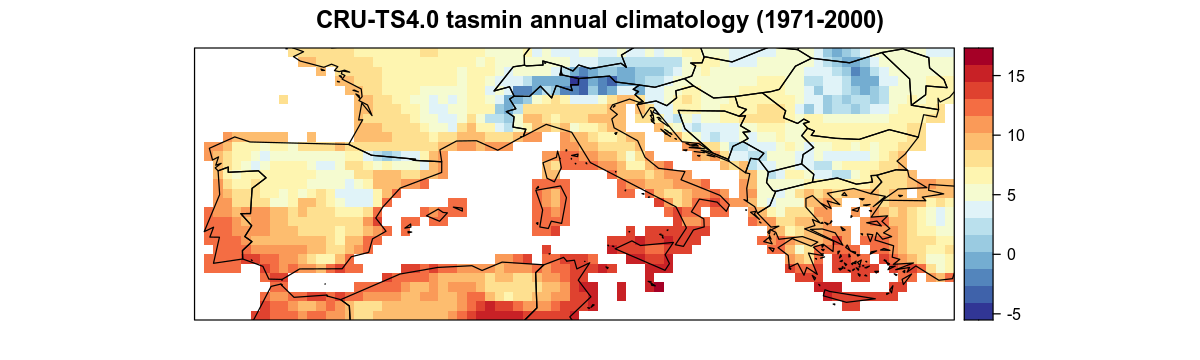

In [10]:
options(repr.plot.width=10, repr.plot.height=3)

spatialPlot(climatology(tasmin.cru),
  backdrop.theme = "countries",
  rev.colors = TRUE,
  main = "CRU-TS4.0 tasmin annual climatology (1971-2000)"
)

### 2. CORDEX historical experiment data, period 1971-2000

Now with the functions from the `loadeR` package we can access simulations data available through UDG server, which steps are already explained in the initial [exercise](https://github.com/SantanderMetGroup/training-climate4r/blob/BuenosAires2022/02_First_steps_in_climate4R/02_First_Steps_in_Climate4R.ipynb). 

There are many available datasets via UDG server. `UDG.datasets` lists all the available datasets, and here for the exercise we will use Euro-CORDEX simulations with the RACMO22E on 0.44 degree grid (EUR-44), forced with ICHEC-EC-EARTH global model. 

To list the available files that maches the above requests, we can look for the files that fit the pattern: 

In [11]:
filelist <- UDG.datasets(pattern = "EUR-44.*ICHEC-EC-EARTH.*r1i1p1.*RACMO22E")

Matches found for: CORDEX
Label names are returned, set argument full.info = TRUE to get more information


Lets see the list of the vailable files:

In [12]:
# To list the all the files that fit the pattern:
filelist

$CORDEX
[1] "CORDEX-EUR-44_ICHEC-EC-EARTH_historical_r1i1p1_KNMI-RACMO22E_v1"
[2] "CORDEX-EUR-44_ICHEC-EC-EARTH_rcp45_r1i1p1_KNMI-RACMO22E_v1"     
[3] "CORDEX-EUR-44_ICHEC-EC-EARTH_rcp85_r1i1p1_KNMI-RACMO22E_v1"

Now we have names of the files and will can load the data using the `loadGridData` function from the `loadeR` package. To load the part of the domain, first we define the boundaries of the subdomain: 

```R
lonLim <- c(-10, 30)
latLim <- c(34, 48)
```

Now we can load minimum tamperature from the historical files for the above defined subset, 30-year period, and while loading we calculate the monthly mean by using the `aggr.m = "mean"` argument: 

```R
tasmin.hist <- loadGridData(dataset = "CORDEX-EUR-44_MPI-M-MPI-ESM-LR_historical_r1i1p1_SMHI-RCA4_v1",
  var = "tasmin",
  lonLim = lonLim,
  latLim = latLim,
  years = 1971:2000,
  time = "DD",
  aggr.m = "mean")
```

In [13]:
# To load faster, we can load already prepared raw data from the same location as the observations

tasmin.hist <- my_readRDS("https://meteo.unican.es/work/training-climate4r-f43534662sfw/data/impact_indices/tasmin_EC-EARTH_historical_r1i1p1_RACMO22E.rds")

[2022-08-31 16:13:58] - Computing climatology...
[2022-08-31 16:13:58] - Done.


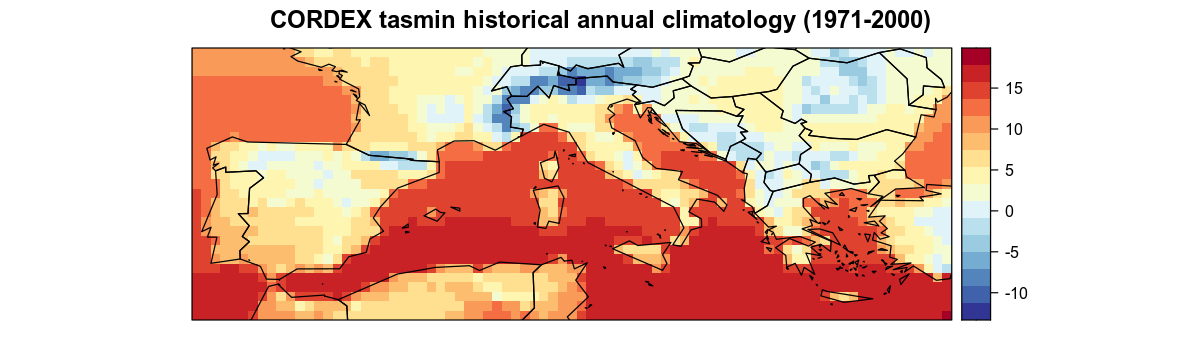

In [14]:
# To check the spatial boundaries, lets plot climatology of the data

spatialPlot(climatology(tasmin.hist),
  backdrop.theme = "countries",
  rev.colors = TRUE,
  main = "CORDEX tasmin historical annual climatology (1971-2000)"
)

The format of the time variable has to be the same in observational and simulated data set, which is a requisite for bias correction:

In [15]:
head(tasmin.scru$Dates$start)
head(tasmin.hist$Dates$start)

[1] "1971-01-16 00:00:00 GMT" "1971-02-15 00:00:00 GMT"
[3] "1971-03-16 00:00:00 GMT" "1971-04-16 00:00:00 GMT"
[5] "1971-05-16 00:00:00 GMT" "1971-06-16 00:00:00 GMT"

[1] "1971-01-01 GMT" "1971-02-01 GMT" "1971-03-01 GMT" "1971-04-01 GMT"
[5] "1971-05-01 GMT" "1971-06-01 GMT"

In [17]:
tasmin.scru$Dates <- tasmin.hist$Dates
head(tasmin.scru$Dates$start)
head(tasmin.hist$Dates$start)

[1] "1971-01-01 GMT" "1971-02-01 GMT" "1971-03-01 GMT" "1971-04-01 GMT"
[5] "1971-05-01 GMT" "1971-06-01 GMT"

[1] "1971-01-01 GMT" "1971-02-01 GMT" "1971-03-01 GMT" "1971-04-01 GMT"
[5] "1971-05-01 GMT" "1971-06-01 GMT"

Next, we ensure that the data are in degress Celsius (model data are originally stored in Kelvin in
most cases using the function `udConvertGrid` from the new package `convertR`:

In [18]:
tasmin.hist <- udConvertGrid(tasmin.hist, new.units = "degC")

The data has to be on the same grid as observations, so we have to regrid the data to the reference regular grid from the CRU defined before as `ref.grid`. This is done using the `interpGrid` function from package `transformeR`:

In [19]:
tasmin.hist <- interpGrid(tasmin.hist, new.coordinates = ref.grid)

[2022-08-31 16:14:26] Calculating nearest neighbors...
[2022-08-31 16:14:26] Performing nearest interpolation... may take a while
[2022-08-31 16:14:26] Done


The function `biasCorrection` of the package `downscaleR` allows for applying a number of standard bias
correction techniques within the climate4R framework (see more details in one of the [notebooks](https://github.com/SantanderMetGroup/training-climate4r/blob/BuenosAires2022/03_Downscaling/03_Downscaling_and_Bias_Correction_in_Climate4R.ipynb) from previous classes. In particular, when dealing with monthly
data, the common bias correction technique is the local scaling
method (additive and/or multiplicative). We apply it now to the historical data, using as reference the CRU observations:

In [ ]:
tasmin.hist.corr <- biasCorrection(tasmin.hist,
                                   y = tasmin.scru,
                                   method = "scaling",
                                   scaling.type = "additive") 

tasmin.hist.corr <-redim(tasmin.hist.corr,drop = TRUE)

Lets check what we got:

In [ ]:
spatialPlot(makeMultiGrid(climatology(tasmin.hist), climatology(tasmin.scru), 
                          climatology(tasmin.hist.corr)), backdrop.theme = "coastline",
            as.table = TRUE, names.attr = c("RCM RAW", "OBS", "RCM BC"), layout=c(1,3))

**Exercise:**  
Follow the same procedure for `tasmax` and `pr` to produce variables `tasmax.hist.corr` and `pr.hist.corr`:
1. Load data with the function `loadGridData` (or `my_readRDS` reading file `varname_EC-EARTH_historical_r1i1p1_RACMO22E.rds`
2. Correct unit with `udConvertGrid`
3. Interpolate data with `interpGrid`
4. Correct bias using the function `biasCorrection`

```R
# Bias correcting historical tasmax
tasmax.hist <- my_readRDS("https://meteo.unican.es/work/training-climate4r-f43534662sfw/data/impact_indices/tasmax_EC-EARTH_historical_r1i1p1_RACMO22E.rds")
tasmin.hist <- udConvertGrid(tasmin.hist, new.units = "degC")
tasmin.hist <- interpGrid(tasmin.hist, new.coordinates = ref.grid)
tasmax.hist.corr <- biasCorrection(tasmax.hist,
    y = tasmax.scru,
    method = "scaling",
    scaling.type = "additive")

# Bias correcting historical pr
pr.hist <- my_readRDS("https://meteo.unican.es/work/training-climate4r-f43534662sfw/data/impact_indices/pr_EC-EARTH_historical_r1i1p1_RACMO22E.rds")
pr.hist <- udConvertGrid(pr.hist, new.units = "degC")
pr.hist <- interpGrid(pr.hist, new.coordinates = ref.grid)
pr.hist.corr <- biasCorrection(pr.hist,
    y = pr.scru,
    method = "scaling",
    scaling.type = "additive")
```

### 3. CORDEX RCP 8.5 experiment data, period 2010:2100

To load the future (years = 2010:2100) data from the RCP 8.5 experiment, the procedure is similar as for the historical data.
Firts we look for the file to load from the filelist that cintains these key strings: EUR-44, RACMO22E, EC-EARTH, and RCP 8.5 (instead if historical):


In [ ]:
# Lets check the list of files:
filelist

The file that fits the pattern is `CORDEX-EUR-44_ICHEC-EC-EARTH_rcp85_r1i1p1_KNMI-RACMO22E_v1`, and normaly can be also downloaded using `loadGridData`, which would need some time to load. 

```R
tasmin.85 <- loadGridData(dataset = "CORDEX-EUR-44_ICHEC-EC-EARTH_rcp85_r1i1p1_KNMI-RACMO22E_v1",
  var = "tasmin",
  lonLim = lonLim,
  latLim = latLim,
  years = 2010:2100,
  time = "DD",
  aggr.m = "mean")
tasmin.85 <- udConvertGrid(new.units = "degC")
tasmin.85 <- interpGrid(tasmin.85, new.coordinates = ref.grid)
```

As before, we prepared files to be loaded faster using `my_readRDS`:

In [ ]:
tasmin.85 <- my_readRDS("https://meteo.unican.es/work/training-climate4r-f43534662sfw/data/impact_indices/tasmin_EC-EARTH_rcp85_r1i1p1_RACMO22E.rds")
tasmin.85 <- udConvertGrid(tasmin.85, new.units = "degC")
tasmin.85 <- interpGrid(tasmin.85, new.coordinates = ref.grid)
tasmin.85.corr <- biasCorrection(tasmin.85,
    y = tasmin.scru,
    method = "scaling",
    scaling.type = "additive")

**Exercise:**  
Follow the same procedure for `tasmax` and `pr` to produce variables `tasmax.85.corr` and `pr.85.corr`:
1. Load data with the function `loadGridData` (or my_readRDS reading file `varname_EC-EARTH_rcp85_r1i1p1_RACMO22E.rds`
2. Correct unit with `udConvertGrid`
3. Interpolate data with `interpGrid`
4. Correct bias using the function `biasCorrection`

```R
# Bias correcting projected tasmax
tasmax.85 <- my_readRDS("https://meteo.unican.es/work/training-climate4r-f43534662sfw/data/impact_indices/tasmin_EC-EARTH_rcp85_r1i1p1_RACMO22E.rds")
tasmax.85 <- udConvertGrid(tasmax.85, new.units = "degC")
tasmax.85 <- interpGrid(tasmax.85, new.coordinates = ref.grid)
tasmax.85.corr <- biasCorrection(tasmax.85,
    y = tasmax.scru,
    method = "scaling",
    scaling.type = "additive")

# Bias correcting projected pr
pr.85 <- my_readRDS("https://meteo.unican.es/work/training-climate4r-f43534662sfw/data/impact_indices/tasmin_EC-EARTH_rcp85_r1i1p1_RACMO22E.rds")
pr.85 <- udConvertGrid(pr.85, new.units = "degC")
pr.85 <- interpGrid(pr.85, new.coordinates = ref.grid)
pr.85.corr <- biasCorrection(pr.85,
    y = pr.scru,
    method = "scaling",
    scaling.type = "additive")
```

## Calculating future SPEI

### 1. Binding bias corrected variables

Once both the historical and the RCP 8.5 projections have been bias-corrected using the CRU
observations as reference, these can be joined along time into a single object, to have a continuous time series so that SPEI can be computee. This is achieved by the function `bindGrid` from package
`transformeR`:

In [ ]:
#binding tasmax
tx <- bindGrid(tasmax.hist.corr, tasmax.85.corr, dimension = "time") 
redim(tx, drop = TRUE)

#binding tasmin
tn <- bindGrid(tasmin.hist.corr, tasmin.85.corr, dimension = "time")
redim(tn, drop = TRUE)

#binding 
pr <- bindGrid(pr.hist.corr, pr.85.corr, dimension = "time") 
redim(pr, drop = TRUE)

### 2. Potential evapotransipration

To calculate SPEI, it is necessary to calculate potential evapotransipration. The function `petGrid`
of the new `climate4R` package `drought4R` is used to estimate Potential Evapotranspiration, and in this case we use the `hargreaves` method [ see help(hargreaves, package = "SPEI") for more details on the selected method]:

In [ ]:
pet.har.85 <- petGrid(tasmin = tn, tasmax = tx, pr = pr, method = "hargreaves")

Finally, `speiGrid` is used from the `SPEI` package. The index is computed considering the historical reference period (1971-2000), and thefore we define the arguments `ref.start = c(1971, 1)` and `ref.end = c(2000, 12)`, and for the scale of 12 months - argument `scale = 12`:

### 3. Calculating and plotting future SPEI

In [ ]:
spei.rcp85 <- speiGrid(et0.grid = pet.har.85,
    pr.grid = pr,
    scale = 12,
    ref.start = c(1971, 1),
    ref.end = c(2000, 12),
    na.rm = TRUE)

Let's plot time series of SPEI for the RCP 8.5 experiment for grid point nearest to Madrid (Spain) shows the RCP 8.5 SPEI. To get only projected values and for the single point of Madrid, we perform `subsetGrid` in space and time:

In [ ]:
m <- subsetGrid(spei.rcp85, lonLim = -3.43, latLim = 40.23, years = 2010:2100)

Finally we plot timeseries of the subset data:

In [ ]:
plot(ts(m$Data, start = c(2010,1), frequency = 12),
    main = "SPEI-12 (Hargreaves) RCP 8.5 Projection\nCalibration period: 1971-2000",
    ylab = "SPEI-12")
grid()
abline(h = 0)
mtext("Madrid, 3.43W / 40.23N")